<a href="https://colab.research.google.com/github/mitsuogui/Face-Recognition-Proyect-Talller/blob/main/III_ETAPA_ASISTENTE_AULAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instituto Tecnológico de Costa Rica
### Reconocimiento de Rostros
Author: Marco Antonio Quiros Cabezas
 Juan Pablo González Ramírez


Note: When using this notebook, you must select a GPU Hardware Accelerator instead of CPU. Go to Runtime->Change Runtime Type and select any option that uses GPU.

# Dependencies

In [3]:
import pickle #para guardar archivos

import os  #para guardar y manejar carpetas automatico

import datetime
!pip install face_recognition         # Install face_recognition package using pip
import face_recognition
import cv2                            # Import OpenCV
import numpy as np
from matplotlib import pyplot as plt  # pyplot

# ipywidgets packages
import ipywidgets as widgets
from IPython.display import display, clear_output

# Live Streaming dependencies
from IPython.display import Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time



# Utils

## Montar carpetas google

In [24]:
from google.colab import drive
drive.mount('/content/drive')
drive_folder="/content/drive/MyDrive/III E Asistente Aula"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import os

# Nombre de la carpeta que deseas crear
carpeta_nombre = "III E Asistente Aula"

# Ruta completa en tu Google Drive
carpeta_ruta = '/content/drive/My Drive/' + carpeta_nombre

# Comprueba si la carpeta ya existe, y si no, créala
if not os.path.exists(carpeta_ruta):
    os.mkdir(carpeta_ruta)
    print(f'Se ha creado la carpeta: {carpeta_nombre}')
else:
    print(f'La carpeta {carpeta_nombre} ya existe en tu Google Drive.')





La carpeta III E Asistente Aula ya existe en tu Google Drive.


## In-memory data

In [26]:
registered_faces = {}

## face recognition

In [27]:
def check_if_face_registered(face_encoding):
  for _, registered_face in registered_faces.items():
    if True in face_recognition.compare_faces([face_encoding], registered_face):
      return True
  return False

## Real time streaming

In [28]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 800, 600);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 800; //video.videoWidth;
      captureCanvas.height = 600; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [29]:
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

# Register Faces

In [31]:
# Create a text input widget for the name
name_input = widgets.Text(
    placeholder='Enter your name',
    description='Name:',
    disabled=False
)

# Create a file upload widget
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

or_text = widgets.HTML(
    value=" or "
)

# Create a button to trigger face registration
register_button = widgets.Button(description='Register Face')

# Create a button to trigger image capture
capture_button = widgets.Button(description='Capture Image')

# Create an output widget to display the uploaded or captured face image
output = widgets.Output()

# Initialize variables to store the uploaded image and name
uploaded_image_data = None
registered_name = None

# Define a function to handle image upload
def handle_upload(change):
    global uploaded_image_data
    uploaded_filename = list(upload_button.value.keys())[0]
    uploaded_image_data = upload_button.value[uploaded_filename]['content']

    with output:
        clear_output()
        display(widgets.Image(value=uploaded_image_data))

    # Assuming uploaded_image_data is binary image data in bytes
    image_array = np.frombuffer(uploaded_image_data, np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

    # Convert the image to RGB format
    uploaded_image_data = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def handle_capture(button):
  global uploaded_image_data
  # start streaming video from webcam
  video_stream()
  js_reply = video_frame("Capturing...", "")

  stop_video_stream()  # Stop the video stream after capturing the frame

  if not js_reply:
    with output:
      clear_output()
      print("Error capturing image!")

  # convert JS response to OpenCV Image
  uploaded_image_data = js_to_image(js_reply["img"])

  with output:
    clear_output()
    # Encode the captured frame as PNG
    _, buffer = cv2.imencode('.png', uploaded_image_data)

    # Convert the encoded image to bytes
    image_bytes = buffer.tobytes()
    display(widgets.Image(value=image_bytes))

# Define a function to handle face registration
def handle_register(button):
    global registered_name

    if uploaded_image_data is not None:
        registered_name = name_input.value

        # Detect faces in the frame
        face_locations = face_recognition.face_locations(uploaded_image_data)

        # If there is no face, raise a popup window
        if len(face_locations) == 0:
            with output:
              clear_output()
              print("No face detected in the image!")
              return

        # If there is more than one face, raise a popup window
        if len(face_locations) > 1:
            with output:
              clear_output()
              print("More than one face detected in the image!")
              return

        # Get the face encodings
        face_encodings = face_recognition.face_encodings(uploaded_image_data)

        # Check if the face is registered
        if check_if_face_registered(face_encodings[0]):
            with output:
              clear_output()
              print("Face already registered!")
              return

        with output:
            clear_output()
            print(f"Face registered for {registered_name}")
            registered_faces[registered_name] = face_encodings[0]
            #Crear instancia de Profesor corregir segun ejemplo ahora con nuevo nombre de funcion cambiarlo y guardarlo en el archivo
            #create_professor(registered_name)

upload_button.observe(handle_upload, names='value')
capture_button.on_click(handle_capture)
register_button.on_click(handle_register)

# Create a container for the widgets
container = widgets.VBox([name_input, widgets.HBox([upload_button, or_text, capture_button]), register_button, output])

# Display the container
display(container)
print(registered_faces)


{'Cap': array([-0.09062216,  0.19495229,  0.06029079, -0.04419025, -0.11816053,
        0.06708179, -0.06021199, -0.07005076,  0.06094087,  0.00261364,
        0.25146419, -0.0171326 , -0.29516187,  0.00250618, -0.00852342,
        0.09456374, -0.12365254, -0.12009739, -0.13134667, -0.11135866,
       -0.0339122 ,  0.01771001, -0.03351486,  0.06499168, -0.14644931,
       -0.16342349, -0.05767858, -0.12238894,  0.05577017, -0.07520677,
        0.00669023, -0.04553112, -0.15142466, -0.07653309,  0.05021179,
        0.04557907, -0.17558774, -0.10288519,  0.29702932, -0.05603804,
       -0.06059131,  0.08180249,  0.10229659,  0.29821774,  0.11833971,
        0.03656156,  0.05755048, -0.12296341,  0.08926348, -0.19871739,
        0.10577793,  0.23357885,  0.17251122,  0.09713376,  0.03141869,
       -0.23232061,  0.0606333 ,  0.17364988, -0.20793675,  0.10764362,
        0.06030983, -0.05705672, -0.06538651, -0.11825308,  0.21885628,
        0.07524478, -0.11881845, -0.17120202,  0.1856633

In [32]:
print(registered_name)

Jolie


In [ ]:
print(registered_faces)

In [34]:
for person in registered_faces:
  print(type(person)," : ", person)


<class 'str'>  :  Cap
<class 'str'>  :  Eli
<class 'str'>  :  Strange
<class 'str'>  :  Tony
<class 'str'>  :  Jolie


# Recognize Faces

<IPython.core.display.Javascript object>

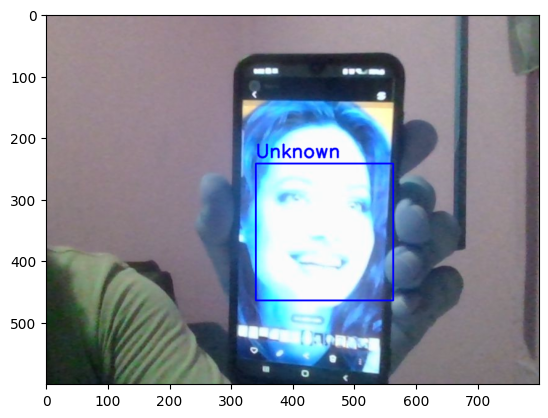

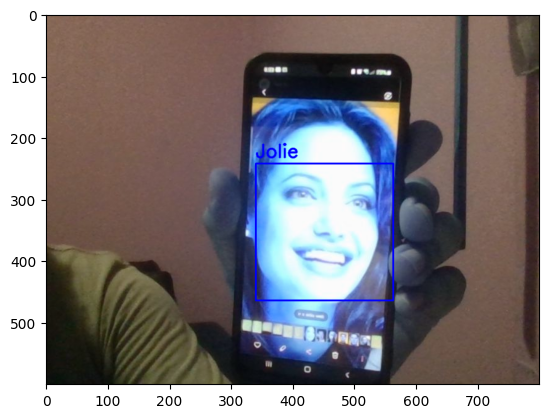

In [35]:

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''

image_counter=1

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])

  # Get the face locations from the frame
  face_locations = face_recognition.face_locations(frame)

  # For each face in the frame
  for (top, right, bottom, left) in face_locations:
      # Draw a rectangle around the face
      cv2.rectangle(
          frame,
          (left, top),
          (right, bottom),
          (0, 0, 255),
          2,
      )
      # Get the face encoding of the face
      face_encoding = face_recognition.face_encodings(frame, [(top, right, bottom, left)])[0]

      # Compare the face encoding to the faces in the database
      matches = face_recognition.compare_faces(list(registered_faces.values()), face_encoding)

      # If there is a match
      if True in matches:
          # Get the index of the match
          match_index = matches.index(True)

          # Get the name of the match
          match_name = list(registered_faces.keys())[match_index]

          # Draw the name of the match on the frame
          cv2.putText(
              frame,
              match_name,
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )
      else:
          # Draw unknown on the frame
          cv2.putText(
              frame,
              "Unknown",
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )

  # Show image
  plt.imshow(frame)
  plt.show()

  if True in matches:
    # ...

    # Guardar la imagen de la cara en Google Drive
    image_name = f'face_{match_name}_{image_counter}.jpg'
    image_path = drive_folder + '/' + image_name  # Agrega el nombre del archivo a la ruta de la carpeta en Drive

    # Guardar la imagen en Google Drive
    cv2.imwrite(image_path, frame[top:bottom, left:right])

    # Incrementar el contador de imágenes
    image_counter += 1


### Anterior recognize faces

# Add information


## Add professor

In [ ]:
import pickle
import ipywidgets as widgets
from IPython.display import display

class Professor:
    """
    The code defines a class called Professor with various attributes and methods.pulsa

    :param identification: The identification parameter is used to store the unique identification
    number of the professor. This could be a government-issued ID number or any other unique identifier
    :param name: The name parameter represents the name of the professor
    :param birthday: The birthday parameter is used to store the date of birth of the professor
    :param nationality: The nationality parameter represents the nationality of the professor. It is a
    string that specifies the country or region of origin of the professor
    :param phone_numbers: The `phone_numbers` parameter is a dictionary that stores the phone numbers of
    the professor. The keys of the dictionary represent the type of phone number (e.g., "home", "work",
    "mobile"), and the values represent the actual phone numbers
    :param emails: The "emails" parameter is a list that stores the email addresses of the professor
    :param address: The address parameter is used to store the address of the professor. It can be a
    string that includes the street name, city, state, and postal code
    :param speciality: The "speciality" parameter in the Professor class represents the area of
    expertise or specialization of the professor. It could be a specific subject or field in which the
    professor has extensive knowledge and experience
    :param years_in_institution: The parameter "years_in_institution" represents the number of years the
    professor has been working in the institution. It is used to track the professor's experience and
    tenure in the institutionpulsa
    :param vehicle_license_plate: The parameter "vehicle_license_plate" is used to store the license
    plate number of the vehicle owned by the professor
    :param age: The "age" parameter represents the age of the professor
    """

    registered_faces = registered_faces  # Aquí se debería definir la lista de nombres registrados

    def __init__(self, identification, name, birthday, nationality, phone_numbers, emails, address, speciality, years_in_institution, vehicle_license_plate, age):
        self.identification = identification
        self.name = name
        self.birthday = birthday
        self.nationality = nationality
        self.phone_numbers = phone_numbers
        self.emails = emails
        self.address = address
        self.speciality = speciality
        self.years_in_institution = years_in_institution
        self.vehicle_license_plate = vehicle_license_plate
        self.age = age

def add_professor(drive_folder):
    print("Add professor information: ")
    archivo = f"{drive_folder}/professors.bin"
    professors = []

    try:
        with open(archivo, 'rb') as f:
            professors = pickle.load(f)
    except FileNotFoundError:
        pass

    def submit_professor_info(identification, name, birthday, nationality, telephone, cellphone, emails, address, speciality, years_in_institution, vehicle_license_plate, age):
        phone_numbers = {'telephone': telephone, 'cellphone': cellphone}
        new_professor = Professor(
            identification, name, birthday, nationality, phone_numbers,
            emails.split(','), address, speciality, years_in_institution,
            vehicle_license_plate, age
        )
        if new_professor.name not in Professor.registered_faces:
            print(f"{new_professor.name}'s professor is not registered.")
            return  # No se registra el profesor si no está en la lista

        professors.append({
            'identification': new_professor.identification,
            'name': new_professor.name,
            'birthday': new_professor.birthday,
            'nationality': new_professor.nationality,
            'phone_numbers': new_professor.phone_numbers,
            'emails': new_professor.emails,
            'address': new_professor.address,
            'speciality': new_professor.speciality,
            'years_in_institution': new_professor.years_in_institution,
            'vehicle_license_plate': new_professor.vehicle_license_plate,
            'age': new_professor.age
        })

        with open(archivo, 'wb') as f:
            pickle.dump(professors, f)

        display(widgets.HBox([yes_button, no_button]))

    identification = widgets.Text(description='ID:')
    name = widgets.Text(description='Name:')
    birthday = widgets.Text(description='Birthday (yyyy-mm-dd):')
    nationality = widgets.Text(description='Nationality:')
    telephone = widgets.Text(description='Telephone:')
    cellphone = widgets.Text(description='Cellphone:')
    emails = widgets.Text(description='Email(s) separated by commas:')
    address = widgets.Text(description='Address:')
    speciality = widgets.Text(description='Specialty:')
    years_in_institution = widgets.Text(description='Years in Institution:')
    vehicle_license_plate = widgets.Text(description='Vehicle License Plate or "n/a":')
    age = widgets.Text(description='Age:')

    submit_button = widgets.Button(description='Submit')
    display(identification, name, birthday, nationality, telephone, cellphone,
            emails, address, speciality, years_in_institution,
            vehicle_license_plate, age, submit_button)

    def on_submit_button_prof(b):
        submit_professor_info(identification.value, name.value, birthday.value,
                              nationality.value, telephone.value, cellphone.value,
                              emails.value, address.value, speciality.value,
                              years_in_institution.value, vehicle_license_plate.value,
                              age.value)
    def clear_fields():
        identification.value = ''
        name.value = ''
        birthday.value = ''
        nationality.value = ''
        telephone.value = ''
        cellphone.value = ''
        emails.value = ''
        address.value = ''
        speciality.value = ''
        years_in_institution.value = ''
        vehicle_license_plate.value = ''
        age.value = ''

    def on_submit_button_clicked(b):
        submit_professor_info(identification.value, name.value, birthday.value,
                              nationality.value, telephone.value, cellphone.value,
                              emails.value, address.value, speciality.value,
                              years_in_institution.value, vehicle_license_plate.value,
                              age.value)
        clear_fields()


    submit_button.on_click(on_submit_button_prof)
    clear_fields()

    print("Do you want to add new professor: ")
    yes_button = widgets.Button(description='Yes')
    no_button = widgets.Button(description='No')
    yes_button.on_click(add_professor)
    no_button.on_click(lambda _: print('Process finished.'))

    return widgets.HBox([yes_button, no_button])

add_professor("/content/drive/MyDrive/III E Asistente Aula")




## Add Student

In [ ]:
class Student:
    """
    The `student_info` function prompts the user to enter information about a student and returns a
    `Student` object with the entered information.

    :param identification: The identification parameter is used to store the student's ID number. It
    could be a unique identifier assigned by the school or any other identification number associated
    with the student
    :param name: The name parameter is used to store the name of the student
    :param birthday: The birthday parameter is used to store the student's date of birth
    :param nationality: The nationality parameter represents the nationality of the student. It is a
    string that indicates the country of origin or citizenship of the student
    :param phone_numbers: The `phone_numbers` parameter is a dictionary that stores the student's
    telephone and cellphone numbers. The keys of the dictionary are `'telephone'` and `'cellphone'`, and
    the values are the corresponding phone numbers entered by the user
    :param emails: The `emails` parameter is a list that stores the email addresses of the student. It
    is initialized as an empty list and is populated by taking input from the user. The user is asked to
    enter the student's email(s) separated by commas, and the input is then split into individual email
    addresses
    :param address: The address parameter in the Student class represents the student's residential
    address. It is a string that stores the complete address of the student's residence
    :param degree: The "degree" parameter in the Student class represents the degree or level of
    education that the student is pursuing or has achieved. It could be a specific degree program such
    as "Bachelor of Science" or "Master of Arts", or it could be a general level such as "Undergraduate"
    or "
    :param scholarchip: The parameter "scholarchip" represents the type of scholarship that the student
    has. If the student does not have a scholarship, the value should be set to 0
    :param transport: The "transport" parameter in the Student class represents the type of transport
    that the student uses. It could be a bus, car, bicycle, walking, etc
    :param age: The "age" parameter in the Student class represents the age of the student. It is a
    numerical value that indicates the age of the student
    """
    registered_faces = registered_faces  # Hacer la lista de nombres registrados accesible desde la clase

    def __init__(self, identification, name, birthday, nationality, phone_numbers, emails, address, degree, scholarchip, transport, age):
        self.identification = identification
        self.name = name
        self.birthday = birthday
        self.nationality = nationality
        self.phone_numbers = phone_numbers  # diccionario
        self.emails = emails  # una lista
        self.address = address
        self.degree = degree
        self.scholarchip = scholarchip
        self.transport = transport
        self.age = age


def add_student(drive_folder):
    print("Add student information: ")
    archivo = f"{drive_folder}/students.bin"
    students = []

    try:
        with open(archivo, 'rb') as f:
            students = pickle.load(f)
    except FileNotFoundError:
        pass

    def submit_student_info(identification, name, birthday, nationality, telephone, cellphone, emails, address,
                            degree, scholarchip, transport, age):
        phone_numbers = {'telephone': telephone, 'cellphone': cellphone}
        new_student = Student(
            identification, name, birthday, nationality, phone_numbers,
            emails.split(','), address, speciality, degree,
            scholarchip, age
        )
        if new_student.name not in Student.registered_faces:
            print(f"{new_student.name}'s student is not registered.")
            return  # No se registra en la lista

        students.append({
            'identification': new_student.identification,
            'name': new_student.name,
            'birthday': new_student.birthday,
            'nationality': new_student.nationality,
            'phone_numbers': new_student.phone_numbers,
            'emails': new_student.emails,
            'address': new_student.address,
            'degree': new_student.degree,
            'scholarchip': new_student.scholarchip,
            'transport': new_student.transport,
            'age': new_student.age
        })

        with open(archivo, 'wb') as f:
            pickle.dump(students, f)

        display(widgets.HBox([yes_button, no_button]))

    identification = widgets.Text(description='ID:')
    name = widgets.Text(description='Name:')
    birthday = widgets.Text(description='Birthday (yyyy-mm-dd):')
    nationality = widgets.Text(description='Nationality:')
    telephone = widgets.Text(description='Telephone:')
    cellphone = widgets.Text(description='Cellphone:')
    emails = widgets.Text(description='Email(s) separated by commas:')
    address = widgets.Text(description='Address:')
    degree = widgets.Text(description='Degree:')
    scholarchip = widgets.Text(description='Scholarchip:')
    transport = widgets.Text(description='Transport:')
    age = widgets.Text(description='Age:')

    submit_button = widgets.Button(description='Submit')
    display(identification, name, birthday, nationality, telephone, cellphone,
            emails, address, degree, scholarchip,
            transport, age, submit_button)

    def on_submit_button_prof(b):
        submit_student_info(identification.value, name.value, birthday.value,
                              nationality.value, telephone.value, cellphone.value,
                              emails.value, address.value, degree.value,
                              scholarchip.value, transport.value,
                              age.value)
    def clear_fields():
        identification.value = ''
        name.value = ''
        birthday.value = ''
        nationality.value = ''
        telephone.value = ''
        cellphone.value = ''
        emails.value = ''
        address.value = ''
        degree.value = ''
        scholarchip.value = ''
        transport.value = ''
        age.value = ''

    def on_submit_button_clicked(b):
        submit_student_info(identification.value, name.value, birthday.value,
                              nationality.value, telephone.value, cellphone.value,
                              emails.value, address.value, degree.value,
                              scholarchip.value, transport.value,
                              age.value)
        clear_fields()


    submit_button.on_click(on_submit_button_prof)
    clear_fields()

    print("Do you want to add new professor: ")
    yes_button = widgets.Button(description='Yes')
    no_button = widgets.Button(description='No')
    yes_button.on_click(add_professor)
    no_button.on_click(lambda _: print('Process finished.'))

    return widgets.HBox([yes_button, no_button])

add_professor("/content/drive/MyDrive/III E Asistente Aula")


In [ ]:




    @classmethod
    def student_info(cls):
        while True:
            name = input("Enter student's name (nombre para face_recognition): ")
            if name in cls.registered_faces:
                break
            else:
                print("The person is not registered.")
                again = input("Do you want to enter another student? (y/n): ")
                if again.lower() != "y":
                    return None

        identification = input("Enter the student's ID: ")
        birthday = input("Enter student's birthday: ")
        nationality = input("Enter student's nationality: ")

        phone_numbers = {}
        phone_numbers['telephone'] = input("Enter student's telephone number: ")
        phone_numbers['cellphone'] = input("Enter student's cellphone number: ")

        emails = input("Enter student's email(s) separated by commas: ").split(',')

        address = input("Enter student's address: ")
        degree = input("Enter student's degree: ")
        scholarchip = input("Enter the type of scholarship, if none put 0: ")
        transport = input("Enter the type of transport: ")
        age = input("Enter student's age: ")
        return cls(identification, name, birthday, nationality, phone_numbers, emails, address, degree, scholarchip, transport, age)

def add_student(drive_folder):
    """
    The function `add_student()` prompts the user to enter information about a student and returns a
    dictionary containing the student's information.
    :return: a dictionary containing the student's information.
    """
    archivo = f"{drive_folder}/students.bin"
    students = []

    try:
        with open(archivo, 'rb') as f:
            students = pickle.load(f)
    except FileNotFoundError:
        pass

    while True:
        new_student = Student.student_info()
        if new_student is not None:
            students.append({
                'identification': new_student.identification,
                'name': new_student.name,
                'birthday': new_student.birthday,
                'nationality': new_student.nationality,
                'phone_numbers': new_student.phone_numbers,
                'emails': new_student.emails,
                'address': new_student.address,
                'degree': new_student.degree,
                'scholarchip': new_student.scholarchip,
                'transport': new_student.transport,
                'age': new_student.age
            })

            with open(archivo, 'wb') as f:
                pickle.dump(students, f)

        continuar = input("Do you want to add a new student? (y/n): ").strip().lower()
        if continuar != 'y':
            break

# Uso de la función add_student para agregar estudiantes y guardarlos en '/content/drive/MyDrive/III E Asistente Aula/students.pkl'
add_student("/content/drive/MyDrive/III E Asistente Aula")


Enter student's name (nombre para face_recognition): Eli
Enter the student's ID: 1
Enter student's birthday: 01/01/2001
Enter student's nationality: costa
Enter student's telephone number: 
Enter student's cellphone number: 78787878
Enter student's email(s) separated by commas: eli.ave
Enter student's address: valle
Enter student's degree: lic
Enter the type of scholarship, if none put 0: 5
Enter the type of transport: motorcicle
Enter student's age: 22
Do you want to add a new student? (y/n): y
Enter student's name (nombre para face_recognition): misi
The person is not registered.
Do you want to enter another student? (y/n): y
Enter student's name (nombre para face_recognition): Cap
Enter the student's ID: 2
Enter student's birthday: 02/02/2000
Enter student's nationality: costa
Enter student's telephone number: 
Enter student's cellphone number: 45454545
Enter student's email(s) separated by commas: cap.ave
Enter student's address: bajo
Enter student's degree: bach
Enter the type of 

## Add Miscelaneous

In [ ]:
class Miscelaneous:
    """ The above code defines a class with various attributes for a registered face.
        :param identification: The identification parameter is used to store the unique identification
        number of a person. This could be a government-issued ID number, such as a passport number or a
        social security number
        :param name: The name parameter represents the name of the person
        :param birthday: The birthday parameter is used to store the date of birth of a person
        :param nationality: The nationality parameter represents the nationality of the person. It is a
        string that indicates the country of citizenship or origin of the person
        :param phone_numbers: The `phone_numbers` parameter is a dictionary that stores phone numbers. Each
        phone number is associated with a specific label or category. For example, the dictionary could look
        like this:
        :param emails: The "emails" parameter is a list that stores the email addresses associated with the
        registered face
        :param address: The address parameter is used to store the address of the person. It can be a string
        that includes the street name, city, state, and postal code
        :param shift: The shift parameter represents the work shift of the person. It could be a string
        indicating the shift timing, such as "morning", "afternoon", or "night"
        :param gross_salary: The gross_salary parameter represents the salary of the person. It is the total
        amount of money earned by the person before any deductions or taxes are applied
        :param work_sector: The work_sector parameter represents the sector or industry in which the person
        works. It could be a specific field such as technology, healthcare, finance, etc
        :param age: The age parameter represents the age of the person
        """

    registered_faces = registered_faces
    def __init__(self, identification, name, birthday, nationality,phone_numbers, emails, address,shift,gross_salary,work_sector,age):
        self.identification = identification
        self.name = name
        self.birthday = birthday
        self.nationality = nationality
        self.phone_numbers = phone_numbers  # diccionario
        self.emails = emails  # una lista
        self.address = address
        self.shift = shift
        self.gross_salary = gross_salary
        self.work_sector = work_sector
        self.age = age
    @classmethod
    def miscelaneous_info(cls):
        while True:
            name = input("Enter miscelaneous's name : ")
            if name in cls.registered_faces:
                break
            else:
                print("The person is not registered.")
                again = input("Do you want to enter another miscelaneous? (y/n): ")
                if again.lower() != "y":
                    return None

        indentification = input("Enter the id miscelaneous: ")
        birthday = input("Enter miscelaneous's birthday: ")
        nacionality = input("Enter miscelaneous's nationality: ")

        phone_numbers = {}
        phone_numbers['telephone'] = input("Enter miscelaneous's telephone numbers: ")
        phone_numbers['cellphone'] = input("Enter miscelaneous's cellphone numbers: ")

        emails = input("Email(s) miscelaneous (separados por coma): ").split(',')

        address = input("Enter miscelaneous's addres: ")
        shift = input("Enter miscelaneous's shift: ")

        gross_salary= input("Enter the gross_salary: ")
        work_sector = input("Enter the work_sector for example (A1-A9): ")
        age = input("Enter student's age: ")
        return cls(indentification, name, birthday, nacionality, phone_numbers,emails, address,shift , gross_salary, work_sector,age)


def add_miscelaneous(drive_folder):
    """
    The function `add_miscellaneous` prompts the user to enter various information about a miscellaneous
    person, such as identification, name, date of birth, nationality, phone numbers, emails, address,
    shift, gross salary, and work sector, and returns a dictionary containing this information.
    :return: a dictionary containing the miscellaneous information entered by the user.
    """
    archivo = f"{drive_folder}/miscelanies.bin"
    miscelanies = []

    try:
        with open(archivo, 'rb') as f:
            miscelanies = pickle.load(f)
    except FileNotFoundError:
        pass

    while True:
        new_miscelaneous = Miscelaneous.miscelaneous_info()
        if new_miscelaneous is not None:
          miscelanies.append({
              'identification': new_miscelaneous.identification,
              'name': new_miscelaneous.name,
              'birthday': new_miscelaneous.birthday,
              'nationality': new_miscelaneous.nationality,
              'phone_numbers': new_miscelaneous.phone_numbers,
              'emails': new_miscelaneous.emails,
              'address': new_miscelaneous.address,
              'shift': new_miscelaneous.shift,
              'gross_salary': new_miscelaneous.gross_salary,
              'work_sector': new_miscelaneous.work_sector,
                'age': new_miscelaneous.age
          })

          with open(archivo, 'wb') as f:
              pickle.dump(miscelanies, f)

        continuar = input("Do you want to add a new miscelaneous? (y/n): ").strip().lower()
        if continuar != 'y':
            break

# Uso de la función add_student para agregar estudiantes y guardarlos en '/content/drive/MyDrive/III E Asistente Aula/students.pkl'
add_miscelaneous("/content/drive/MyDrive/III E Asistente Aula")




Enter miscelaneous's name : Jol
Enter the id miscelaneous: 3
Enter miscelaneous's birthday: 03/03/1990
Enter miscelaneous's nationality: costa
Enter miscelaneous's telephone numbers: 
Enter miscelaneous's cellphone numbers: 12457812
Email(s) miscelaneous (separados por coma): jol.ave
Enter miscelaneous's addres: valle ferre
Enter miscelaneous's shift: 6-14
Enter the gross_salary: 350000
Enter the work_sector for example (A1-A9): A11-A20
Enter student's age: 33
Do you want to add a new miscelaneous? (y/n): y
Enter miscelaneous's name : misi
The person is not registered.
Do you want to enter another miscelaneous? (y/n): y
Enter miscelaneous's name : Strange
Enter the id miscelaneous: 4
Enter miscelaneous's birthday: 04/04/1989
Enter miscelaneous's nationality: costa
Enter miscelaneous's telephone numbers: 
Enter miscelaneous's cellphone numbers: 35735784
Email(s) miscelaneous (separados por coma): strange.ave
Enter miscelaneous's addres: bajo super
Enter miscelaneous's shift: 6-14
Enter 

## Add Classroom

In [ ]:

class Classroom:
    """
    The function saves a list of Classroom objects to a binary file using the pickle module.

    :param classroom_list: A list of Classroom objects that you want to save to a binary file
    :param filename: The filename parameter is a string that represents the name of the binary file
    where the list of classrooms will be saved
    """
    def __init__(self, number, miscellaneous, air_conditioning_working, capacity):
        self.number = number
        self.miscellaneous = miscellaneous
        self.air_conditioning_working = air_conditioning_working
        self.capacity = capacity

# Define a function to save a list of classrooms to a binary file
def save_classrooms_to_binary_file(classroom_list, filename):
    with open(filename, "wb") as f:
        for classroom in classroom_list:
            pickle.dump(classroom, f)

# Define a function to add a classroom
def add_classroom():
    """
    The function `add_classroom()` prompts the user to enter information about a classroom and returns a
    `Classroom` object.
    :return: a `Classroom` object containing the information about the classroom.
    """
    # Prompt the user to enter information about the classroom
    number = input("Enter the classroom number: ")
    miscellaneous_name = input("Enter the name of the miscellaneous: ")

    # Verify if the miscellaneous is in the list of miscelanies from the file
    with open("/content/drive/MyDrive/III E Asistente Aula/miscelanies.bin", 'rb') as f:
        miscelanies = pickle.load(f)
        miscellaneous_exists = any(d['name'] == miscellaneous_name for d in miscelanies)
        if not miscellaneous_exists:
            print("The miscellaneous is not registered.")
            return None

    air_conditioning_working = input("Is the air conditioning working? (yes/no): ").lower() == "yes"
    capacity = int(input("Enter the classroom capacity: "))

    # Create a Classroom object with the classroom's information
    classroom = Classroom(number, miscellaneous_name, air_conditioning_working, capacity)

    # Return the Classroom object
    return classroom

# Generate the list of classrooms
classroom_list = []

# Request classroom information
while True:
    # Get information from a classroom
    classroom_info = add_classroom()

    if classroom_info is not None:
        # Add classroom
        classroom_list.append(classroom_info)

        # Ask if the user wants to add another classroom
        option = input("Do you want to add another classroom? (y/n): ")
        if option != "y":
            break

# Save the list of classrooms to a binary file
save_classrooms_to_binary_file(classroom_list, "/content/drive/MyDrive/III E Asistente Aula/classrooms.bin")



Enter the classroom number: 01
Enter the name of the miscellaneous: Jol
Is the air conditioning working? (yes/no): yes
Enter the classroom capacity: 24
Do you want to add another classroom? (y/n): y
Enter the classroom number: 02
Enter the name of the miscellaneous: Strange
Is the air conditioning working? (yes/no): no
Enter the classroom capacity: 18
Do you want to add another classroom? (y/n): n


In [ ]:


# Define a function to save a list of classrooms to a binary file
def save_classrooms_to_binary_file(classroom_list, filename):
    with open(filename, "wb") as f:
        pickle.dump(classroom_list, f)

# Define a function to add a classroom
def add_classroom():
    """
    The function `add_classroom()` prompts the user to enter information about a classroom and returns a
    dictionary containing the classroom's information.
    :return: a dictionary containing the information about the classroom.
    """
    # Prompt the user to enter information about the classroom
    number = input("Enter the classroom number: ")
    miscelaneous_name = input("Enter the name of the miscellaneous: ")

    # Verify if the miscellaneous is in the list of miscellanies from the file
    with open("/content/drive/MyDrive/III E Asistente Aula/miscelanies.bin", 'rb') as f:
        miscelanies = pickle.load(f)
        miscelaneous_exists = any(d['name'] == miscelaneous_name for d in miscelanies)
        if not miscelaneous_exists:
            print("The miscelaneous is not registered.")
            return None

    air_conditioning_working = input("Is the air conditioning working? (yes/no): ").lower() == "yes"
    capacity = int(input("Enter the classroom capacity: "))

    # Create a dictionary with the classroom's information
    classroom_info = {
        "number": number,
        "miscelaneous_name": miscelaneous_name,
        "air_conditioning_working": air_conditioning_working,
        "capacity": capacity
    }

    return classroom_info

# Generate the list of classrooms (as dictionaries)
classroom_list = []

# Request classroom information
while True:
    classroom_info = add_classroom()

    if classroom_info is not None:
        # Add classroom info to the list
        classroom_list.append(classroom_info)

        # Ask if the user wants to add another classroom
        option = input("Do you want to add another classroom? (y/n): ")
        if option != "y":
            break

# Save the list of classrooms (as dictionaries) to a binary file
save_classrooms_to_binary_file(classroom_list, "/content/drive/MyDrive/III E Asistente Aula/classrooms.bin")


Enter the classroom number: 01
Enter the name of the miscellaneous: Jol
Is the air conditioning working? (yes/no): yes
Enter the classroom capacity: 24
Do you want to add another classroom? (y/n): y
Enter the classroom number: 02
Enter the name of the miscellaneous: misi
The miscelaneous is not registered.
Enter the classroom number: 02
Enter the name of the miscellaneous: Strange
Is the air conditioning working? (yes/no): no
Enter the classroom capacity: 18
Do you want to add another classroom? (y/n): n


## Add course

In [ ]:

def load_data_from_file(file_path):
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        data = []
    return data

def save_data_to_file(data, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

class Course:
    """ The `course_info` function allows the user to input information about a course, including the course
      code, name, period, career, students, professors, schedule, and classrooms, and saves the course
      information to a file.

      :param course_code: The `course_code` parameter represents the unique code or identifier for a
      course. It is used to distinguish one course from another
      :param course_name: The parameter `course_name` represents the name of the course. It is a string
      that specifies the name of the course being created
      :param period: The "period" parameter in the `__init__` method represents the period or semester in
      which the course is offered. It could be a string value such as "Fall 2021" or "Spring 2022"
      indicating the specific period or semester of the course
      :param career: The "career" parameter in the `__init__` method represents the career or major
      associated with the course. It is a string that specifies the field of study or specialization to
      which the course belongs. For example, if the course is related to computer science, the "career"
      parameter could be
      :param students: The `students` parameter is a list of student names who are enrolled in the course
      :param professors: The "professors" parameter is a list of names of professors who are teaching the
      course
      :param schedule: The "schedule" parameter in the `__init__` method represents the schedule of the
      course. It is a string that specifies the time and days of the week when the course is scheduled to
      take place. For example, it could be "Monday 10:00 AM - 12:00
      :param classrooms: The `classrooms` parameter in the `__init__` method represents the list of
      classroom numbers where the course will be held. It is a list of strings, where each string
      represents a classroom number
      """
    def __init__(self, course_code, course_name, period, career, students, professors, schedule, classrooms):
        self.course_code = course_code
        self.course_name = course_name
        self.period = period
        self.career = career
        self.students = students
        self.professors = professors
        self.schedule = schedule
        self.classrooms = classrooms

    @classmethod
    def course_info(cls):
        while True:
            students_list = load_data_from_file("/content/drive/MyDrive/III E Asistente Aula/students.bin")
            professors_list = load_data_from_file("/content/drive/MyDrive/III E Asistente Aula/professors.bin")

            code = input("Enter the course code: ")
            name = input("Enter the course name: ")
            period = input("Enter the course period: ")
            career = input("Enter the career: ")

            students = input("Enter student names separated by commas: ").split(',')
            professors = input("Enter professor names separated by commas: ").split(',')
            schedule = input("Enter the course schedule: ")
            classrooms = input("Enter the classroom numbers separated by commas: ").split(',')

            # Verify if the students are in the list of students
            for student_name in students:
                if not any(student['name'] == student_name for student in students_list):
                    print(f"The student '{student_name}' is not registered.")
                    return None

            # Verify if the professors are in the list of professors
            for professor_name in professors:
                if not any(professor['name'] == professor_name for professor in professors_list):
                    print(f"The professor '{professor_name}' is not registered.")
                    return None

            new_course = Course(code, name, period, career, students, professors, schedule, classrooms)
            courses_list = load_data_from_file("/content/drive/MyDrive/III E Asistente Aula/courses.bin")
            courses_list.append(new_course.__dict__)
            save_data_to_file(courses_list, "/content/drive/MyDrive/III E Asistente Aula/courses.bin")

            continuar = input("Do you want to add another course? (y/n): ").strip().lower()
            if continuar != 'y':
                break

# Use the function to add courses
Course.course_info()


Enter the course code: c2
Enter the course name: meca
Enter the course period: afternoon
Enter the career: electro
Enter student names separated by commas: Cap
Enter professor names separated by commas: Ton
Enter the course schedule: Lunes, Miercoles
Enter the classroom numbers separated by commas: 02
Do you want to add another course? (y/n): n


## Assitance

<IPython.core.display.Javascript object>

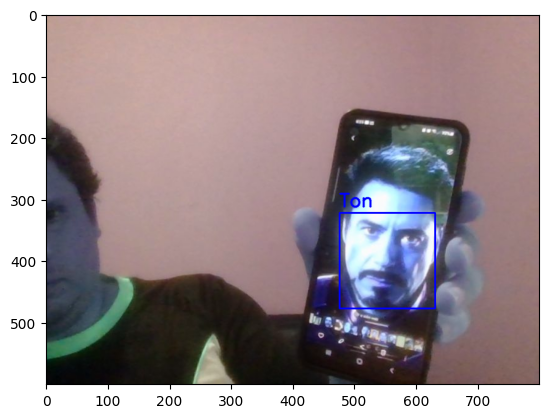

In [ ]:
import cv2
import face_recognition
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''

image_counter = 1

# Cargar la lista de asistencia si ya existe
output_path = '/content/drive/MyDrive/III E Asistente Aula/assistance.bin'
try:
    with open(output_path, 'rb') as f:
        asistencia_list = pickle.load(f)
except FileNotFoundError:
    asistencia_list = []

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # Get the face locations from the frame
    face_locations = face_recognition.face_locations(frame)

    # For each face in the frame
    for (top, right, bottom, left) in face_locations:
        # Draw a rectangle around the face
        cv2.rectangle(
            frame,
            (left, top),
            (right, bottom),
            (0, 0, 255),
            2,
        )
        # Get the face encoding of the face
        face_encoding = face_recognition.face_encodings(frame, [(top, right, bottom, left)])[0]

        # Compare the face encoding to the faces in the database
        matches = face_recognition.compare_faces(list(registered_faces.values()), face_encoding)

        # If there is a match
        if True in matches:
            # Get the index of the match
            match_index = matches.index(True)

            # Get the name of the match
            match_name = list(registered_faces.keys())[match_index]

            # Draw the name of the match on the frame
            cv2.putText(
                frame,
                match_name,
                (left, top - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 255),
                2,
                cv2.LINE_AA,
            )
        else:
            # Draw unknown on the frame
            cv2.putText(
                frame,
                "Unknown",
                (left, top - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 0, 255),
                2,
                cv2.LINE_AA,
            )

    # Show image
    plt.imshow(frame)
    plt.show()

    if True in matches:
        # Guardar la imagen de la cara en Google Drive
        image_name = f'face_{match_name}_{image_counter}.jpg'
        image_path = drive_folder + '/' + image_name  # Agrega el nombre del archivo a la ruta de la carpeta en Drive

        # Guardar la imagen en Google Drive
        cv2.imwrite(image_path, frame[top:bottom, left:right])

        # Incrementar el contador de imágenes
        image_counter += 1

# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))

class Attendance:
    """ The function `create_attendance` takes an image path as input, extracts the name from the file name,
        and returns a dictionary containing the name, image path, and current date and time.

        :param image_path: The `image_path` parameter is a string that represents the path to an image file
        :return: a dictionary named "asistencia" which contains the following keys and values:
        - "nombre": the name extracted from the image file name
        - "image_path": the provided image path
        - "fecha_hora": the current date and time in the format "YYYY-MM-DD HH:MM:SS"
        """
    def create_attendance(self, image_path):
        file_name = image_path.split("/")[-1]  # Obtener el nombre del archivo
        nombre = file_name.split("_")[1]  # Obtener el nombre del archivo a partir de 'face_NOMBRE_NUMERO.jpg'

        asistencia = {
            'nombre': nombre,
            'image_path': image_path,
            'fecha_hora': datetime.now().strftime("%Y-m-d H:M:S")
        }
        return asistencia

class MainApplication:
    def __init__(self):
        self.attendance = Attendance()
        self.image_counter = 1
        self.drive_folder = '/content/drive/MyDrive/III E Asistente Aula'  # Reemplaza con tu ruta

    def process_frame(self, frame, registered_faces):
        # Resto del código para procesar el frame y reconocer caras

        if True in matches:
            # Resto del código para guardar la imagen en Google Drive
            image_name = f'face_{match_name}_{self.image_counter}.jpg'
            image_path = f'{self.drive_folder}/{image_name}'
            cv2.imwrite(image_path, frame[top:bottom, left:right])
            self.image_counter += 1

            asistencia = self.attendance.create_attendance(image_path)
            return asistencia

    def run(self):
        # Resto del código para iniciar el streaming de video

        while True:
            js_reply = video_frame(label_html, bbox)
            if not js_reply:
                break

            frame = js_to_image(js_reply["img"])
            asistencia = self.process_frame(frame, registered_faces)
            if asistencia:
                asistencia_list.append(asistencia)

        # Guardar la lista de asistencia en el archivo binario
        with open(output_path, 'wb') as f:
            pickle.dump(asistencia_list, f)

        # Resto del código para detener el streaming de video

if __name__ == '__main__':
    app = MainApplication()
    app.run()


In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
bbox = ''

image_counter=1

while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
    break

  # convert JS response to OpenCV Image
  frame = js_to_image(js_reply["img"])

  # Get the face locations from the frame
  face_locations = face_recognition.face_locations(frame)

  # For each face in the frame
  for (top, right, bottom, left) in face_locations:
      # Draw a rectangle around the face
      cv2.rectangle(
          frame,
          (left, top),
          (right, bottom),
          (0, 0, 255),
          2,
      )
      # Get the face encoding of the face
      face_encoding = face_recognition.face_encodings(frame, [(top, right, bottom, left)])[0]

      # Compare the face encoding to the faces in the database
      matches = face_recognition.compare_faces(list(registered_faces.values()), face_encoding)

      # If there is a match
      if True in matches:
          # Get the index of the match
          match_index = matches.index(True)

          # Get the name of the match
          match_name = list(registered_faces.keys())[match_index]

          # Draw the name of the match on the frame
          cv2.putText(
              frame,
              match_name,
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )
      else:
          # Draw unknown on the frame
          cv2.putText(
              frame,
              "Unknown",
              (left, top - 10),
              cv2.FONT_HERSHEY_SIMPLEX,
              1,
              (0, 0, 255),
              2,
              cv2.LINE_AA,
          )

  # Show image
  plt.imshow(frame)
  plt.show()

  if True in matches:
    # ...

    # Guardar la imagen de la cara en Google Drive
    image_name = f'face_{match_name}_{image_counter}.jpg'
    image_path = drive_folder + '/' + image_name  # Agrega el nombre del archivo a la ruta de la carpeta en Drive

    # Guardar la imagen en Google Drive
    cv2.imwrite(image_path, frame[top:bottom, left:right])

    # Incrementar el contador de imágenes
    image_counter += 1
from datetime import datetime

# ...
# JavaScript code to stop the webcam stream
js_stop_stream = """
    const stream = video.srcObject;
    const tracks = stream.getTracks();

    tracks.forEach(function(track) {
        track.stop();
    });

    video.srcObject = null;
    div.style.display = 'none';  // Hide the container
"""

# Function to stop the video streaming
def stop_video_stream():
    display(Javascript(js_stop_stream))
# Después de identificar a una persona y guardar la imagen en image_path
file_name = image_path.split("/")[-1]  # Obtener el nombre del archivo
nombre = file_name.split("_")[1]  # Obtener el nombre del archivo a partir de 'face_NOMBRE_NUMERO.jpg'

# Crear un diccionario de asistencia
asistencia = {
    'nombre': nombre,
    'image_path': image_path,
    'fecha_hora': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

# Guardar la asistencia en la lista
asistencia_list = []
output_path = '/content/drive/MyDrive/III E Asistente Aula/assistance.bin'

# Cargar la lista de asistencia si ya existe
try:
    with open(output_path, 'rb') as f:
        asistencia_list = pickle.load(f)
except FileNotFoundError:
    pass

asistencia_list.append(asistencia)

# Guardar la lista actualizada en el archivo binario
with open(output_path, 'wb') as f:
    pickle.dump(asistencia_list, f)


# Requests

##Professor

In [ ]:
def load_data_from_file(file_path):
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        data = []
    return data


def consult_professors():
    """
    The `consult_professors()` function loads data from a file and displays information about each
    professor.
    """
    professors_data = load_data_from_file("/content/drive/MyDrive/III E Asistente Aula/professors.bin")

    for professor in professors_data:
        print("Identification:", professor['identification'])
        print("Name:", professor['name'])
        print("Birthday:", professor['birthday'])
        print("Nationality:", professor['nationality'])
        print("Phone Numbers:")
        for phone_type, phone_number in professor['phone_numbers'].items():
            print(f"  {phone_type}: {phone_number}")
        print("Emails:", ', '.join(professor['emails']))
        print("Address:", professor['address'])
        print("Speciality:", professor['speciality'])
        print("Years in Institution:", professor['years_in_institution'])
        print("Vehicle License Plate:", professor['vehicle_license_plate'])
        print("\n")

# Consult professors and display the information

consult_professors()


##Students

In [ ]:
def load_data_from_file(file_path):
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        data = []
    return data

def consult_students():
    """
    The function `consult_students()` loads student data from a file and prints out the information for
    each student.
    """
    students_data = load_data_from_file("/content/drive/MyDrive/III E Asistente Aula/students.bin")

    for student in students_data:
        print("Identification:", student['identification'])
        print("Name:", student['name'])
        print("Birthday:", student['birthday'])
        print("Nationality:", student['nationality'])
        print("Phone Numbers:")
        for phone_type, phone_number in student['phone_numbers'].items():
            print(f"  {phone_type}: {phone_number}")
        print("Emails:", ', '.join(student['emails']))
        print("Address:", student['address'])
        print("Degree:", student['degree'])
        print("Scholarchip:", student['scholarchip'])
        print("Transport:", student['transport'])
        print("\n")

# Consult professors and display the information
consult_students()



Identification: 1
Name: Eli
Birthday: 01/01/1989
Nationality: tica
Phone Numbers:
  telephone: 
  cellphone: 78787878
Emails: eli.ave
Address: valle
Degree: lic
Scholarchip: 5
Transport: moto


Identification: 2
Name: Cap
Birthday: 02/02/1989
Nationality: tico
Phone Numbers:
  telephone: 
  cellphone: 78787878
Emails: cap.ave
Address: valle
Degree: bach
Scholarchip: 0
Transport: bus




##Miscelaneous

In [ ]:
def load_data_from_file(file_path):
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        data = []
    return data

def consult_miscelanies():
    miscelanies_data = load_data_from_file("/content/drive/MyDrive/III E Asistente Aula/miscelanies.bin")

    for miscelaneous in miscelanies_data:
        print("Identification:", miscelaneous['identification'])
        print("Name:", miscelaneous['name'])
        print("Birthday:", miscelaneous['birthday'])
        print("Nationality:", miscelaneous['nationality'])
        print("Phone Numbers:")
        for phone_type, phone_number in miscelaneous['phone_numbers'].items():
            print(f"  {phone_type}: {phone_number}")
        print("Emails:", ', '.join(miscelaneous['emails']))
        print("Address:", miscelaneous['address'])
        print("Shift:", miscelaneous['shift'])
        print("Gross_salary:", miscelaneous['gross_salary'])
        print("Work_sector:", miscelaneous['work_sector'])
        print("\n")

# Consult professors and display the information
consult_miscelanies()


Identification: 3
Name: Strange
Birthday: 03/03/1985
Nationality: costa
Phone Numbers:
  telephone: 
  cellphone: 45645645
Emails: str.ave
Address: bajo
Shift: 6-14
Gross_salary: 350000
Work_sector: A11-A21


Identification: 4
Name: Jol
Birthday: 04/04/1985
Nationality: costa
Phone Numbers:
  telephone: 
  cellphone: 78784545
Emails: jol.ave
Address: bajo
Shift: 6-14
Gross_salary: 355000
Work_sector: A21-A30




## Classrooms

In [ ]:
import pickle

def load_data_from_file(file_path):
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        data = []
    return data

class Classroom:
    def __init__(self, number, miscelaneous_name, air_conditioning_working, capacity):
        self.number = number
        self.miscelaneous_name = miscelaneous_name
        self.air_conditioning_working = air_conditioning_working
        self.capacity = capacity

def consult_classrooms():
    """
    The function `consult_classrooms()` loads data from a file and prints information about each
    classroom.
    """
    classrooms_data = load_data_from_file("/content/drive/MyDrive/III E Asistente Aula/classrooms.bin")

    for classroom in classrooms_data:
        print("Classroom Number:", classroom['number'])
        print("Miscelaneous Name:", classroom['miscelaneous_name'])
        print("Air Conditioning Working:", classroom['air_conditioning_working'])
        print("Capacity:", classroom['capacity'])
        print("\n")

# Consult classrooms and display the information
consult_classrooms()


Classroom Number: 01
Miscelaneous Name: Jol
Air Conditioning Working: True
Capacity: 24


Classroom Number: 02
Miscelaneous Name: Strange
Air Conditioning Working: False
Capacity: 18




## Courses

In [ ]:
import pickle

def load_data_from_file(file_path):
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    except FileNotFoundError:
        data = []
    return data

class Course:
    def __init__(self, course_code, course_name, period, career, students, professors, schedule, classrooms):
        self.course_code = course_code
        self.course_name = course_name
        self.period = period
        self.career = career
        self.students = students
        self.professors = professors
        self.schedule = schedule
        self.classrooms = classrooms

def get_student_info(student_name, students_data):
    for student in students_data:
        if student['name'] == student_name:
            return student
    return None

def get_professor_info(professor_name, professors_data):
    for professor in professors_data:
        if professor['name'] == professor_name:
            return professor
    return None

def consult_courses():
    courses_data = load_data_from_file("/content/drive/MyDrive/III E Asistente Aula/courses.bin")
    students_data = load_data_from_file("/content/drive/MyDrive/III E Asistente Aula/students.bin")
    professors_data = load_data_from_file("/content/drive/MyDrive/III E Asistente Aula/professors.bin")

    for course in courses_data:
        print("Course Code:", course['course_code'])
        print("Course Name:", course['course_name'])
        print("Period:", course['period'])
        print("Career:", course['career'])
        print("Students:")
        for student_name in course['students']:
            student_info = get_student_info(student_name, students_data)
            if student_info:
                print(f"- {student_info['name']} ({student_info['identification']})")
            else:
                print(f"- {student_name} (Not found in students data)")
        print("Professors:")
        for professor_name in course['professors']:
            professor_info = get_professor_info(professor_name, professors_data)
            if professor_info:
                print(f"- {professor_info['name']} ({professor_info['identification']})")
            else:
                print(f"- {professor_name} (Not found in professors data)")
        print("Schedule:", course['schedule'])
        print("Classrooms:", course['classrooms'])
        print("\n")

# Consult courses and display the information
consult_courses()


Course Code: c1
Course Name: math
Period: morning
Career: compu
Students:
- Cap (2)
- Eli (1)
Professors:
- Ton (07)
Schedule: Miercoles, Viernes
Classrooms: ['01']


Course Code: c2
Course Name: meca
Period: afternoon
Career: electro
Students:
- Cap (2)
Professors:
- Ton (07)
Schedule: Lunes, Miercoles
Classrooms: ['02']




## Students in courses

In [ ]:
import pickle

# Definir una función para cargar datos de un archivo binario
def load_data_from_binary_file(filename):
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        return data
    except FileNotFoundError:
        return []

# Cargar los datos de cursos desde el archivo "courses.bin"
courses_list = load_data_from_binary_file("/content/drive/MyDrive/III E Asistente Aula/courses.bin")

# Cargar los datos de estudiantes desde el archivo "students.bin"
students_info = load_data_from_binary_file("/content/drive/MyDrive/III E Asistente Aula/students.bin")

# Crear un diccionario para almacenar la información de estudiantes usando su nombre como clave
students_dict = {student['name']: student for student in students_info}

# Función para buscar estudiantes en un curso por código o nombre
def find_students_in_course(course_code_or_name):
    """
    The function `find_students_in_course` takes a course code or name as input and returns a list of
    students enrolled in that course, along with a boolean indicating whether the course was found.

    :param course_code_or_name: The parameter `course_code_or_name` is a string that represents either
    the course code or the course name. It is used to search for a course in a list of courses
    :return: a tuple containing two values: the list of students in the specified course and a boolean
    value indicating whether the course was found or not.
    """
    found = False
    students_in_course = []

    for course in courses_list:
        if course_code_or_name == course.get('course_code') or course_code_or_name == course.get('course_name'):
            students = course.get('students', [])
            students_data = [students_dict.get(student, {}) for student in students]
            students_in_course.extend(students_data)
            found = True

    return students_in_course, found

# Función para mostrar toda la información de estudiantes ordenada
def show_students_info(students):
    """
    The function `show_students_info` takes a list of dictionaries representing student information and
    prints out the details of each student.

    :param students: The `students` parameter is expected to be a list of dictionaries. Each dictionary
    represents the information of a student. The dictionary should have the following keys:
    """
    for student in students:
        print("Student Information:")
        print(f"Name: {student.get('name', 'Unknown')}")
        print(f"Age: {student.get('age', 'Unknown')}")
        print(f"Birthday: {student.get('birthday', 'Unknown')}")
        print(f"Nationality: {student.get('nationality', 'Unknown')}")
        print(f"Phone Numbers: {student.get('phone_numbers', {})}")
        print(f"Emails: {', '.join(student.get('emails', []))}")
        print(f"Address: {student.get('address', 'Unknown')}")
        print(f"Degree: {student.get('degree', 'Unknown')}")
        print(f"Scholarship: {student.get('scholarchip', 'Unknown')}")
        print(f"Transport: {student.get('transport', 'Unknown')}")
        print("\n")

# Solicitar al usuario el código o nombre del curso
course_code_or_name = input("Enter the course code or name: ")

students_in_course, found = find_students_in_course(course_code_or_name)

if found:
    # Crear una función para ordenar una lista de diccionarios por la clave 'age'
    def sort_students_by_age(students):
        n = len(students)
        for i in range(n - 1):
            for j in range(0, n - i - 1):
                if students[j]['age'] > students[j + 1]['age']:
                    students[j], students[j + 1] = students[j + 1], students[j]

    # Ordenar la lista de estudiantes por edad
    sort_students_by_age(students_in_course)

    # Mostrar la información de estudiantes ordenada
    show_students_info(students_in_course)
else:
    print("Course not found.")


Enter the course code or name: c1
Student Information:
Name: Eli
Age: 22
Birthday: 01/01/2001
Nationality: costa
Phone Numbers: {'telephone': '', 'cellphone': '78787878'}
Emails: eli.ave
Address: valle
Degree: lic
Scholarship: 5
Transport: motorcicle


Student Information:
Name: Cap
Age: 23
Birthday: 02/02/2000
Nationality: costa
Phone Numbers: {'telephone': '', 'cellphone': '45454545'}
Emails: cap.ave
Address: bajo
Degree: bach
Scholarship: 0
Transport: bus




## Professor in course

In [ ]:

# Definir una función para cargar datos de un archivo binario
def load_data_from_binary_file(filename):
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        return data
    except FileNotFoundError:
        return []

# Cargar los datos de cursos desde el archivo "courses.bin"
courses_list = load_data_from_binary_file("/content/drive/MyDrive/III E Asistente Aula/courses.bin")

# Cargar los datos de profesores desde el archivo "professors.bin"
professors_info = load_data_from_binary_file("/content/drive/MyDrive/III E Asistente Aula/professors.bin")

# Crear un diccionario para almacenar la información de profesores usando su nombre como clave
professors_dict = {professor['name']: professor for professor in professors_info}

# Función para buscar profesores en un curso por código o nombre
def find_professors_in_course(course_code_or_name):
    """
    The function "find_professors_in_course" searches for professors teaching a specific course based on
    the course code or name.

    :param course_code_or_name: The parameter `course_code_or_name` is a string that represents either
    the course code or the course name. It is used to search for a specific course in the `courses_list`
    and retrieve the professors associated with that course
    """
    found = False
    professors_in_course = []

    for course in courses_list:
        if course_code_or_name == course.get('course_code') or course_code_or_name == course.get('course_name'):
            professors = course.get('professors', [])
            professors_data = [professors_dict.get(professor, {}) for professor in professors]
            professors_in_course.extend(professors_data)
            found = True

    return professors_in_course, found

# Función para mostrar toda la información de profesores ordenada por edad
def show_professors_info(professors):
    """
    The function `show_professors_info` takes a list of dictionaries representing professors and prints
    their information.

    :param professors: The `professors` parameter is a list of dictionaries. Each dictionary represents
    the information of a professor. The dictionary should have the following keys:
    """
    for professor in professors:
        print("Professor Information:")
        print(f"Name: {professor.get('name', 'Unknown')}")
        print(f"Age: {professor.get('age', 'Unknown')}")
        print(f"Birthday: {professor.get('birthday', 'Unknown')}")
        print(f"Nationality: {professor.get('nationality', 'Unknown')}")
        print(f"Phone Numbers: {professor.get('phone_numbers', {})}")
        print(f"Emails: {', '.join(professor.get('emails', []))}")
        print(f"Address: {professor.get('address', 'Unknown')}")
        print(f"Speciality: {professor.get('speciality', 'Unknown')}")
        print(f"Years in Institution: {professor.get('years_in_institution', 'Unknown')}")
        print(f"Vehicle License Plate: {professor.get('vehicle_license_plate', 'Unknown')}")
        print("\n")

# Solicitar al usuario el código o nombre del curso
course_code_or_name = input("Enter the course code or name: ")

professors_in_course, found = find_professors_in_course(course_code_or_name)

if found:
    # Crear una función para ordenar una lista de diccionarios por la clave 'age'
    def sort_professors_by_age(professors):
        n = len(professors)
        for i in range(n - 1):
            for j in range(0, n - i - 1):
                if professors[j]['age'] > professors[j + 1]['age']:
                    professors[j], professors[j + 1] = professors[j + 1], professors[j]

    # Ordenar la lista de profesores por edad
    sort_professors_by_age(professors_in_course)

    # Mostrar la información de profesores ordenada por edad
    show_professors_info(professors_in_course)
else:
    print("Course not found.")


## Assitance by course

In [ ]:
import pickle
from datetime import datetime
from PIL import Image
import IPython.display as display

# Cargar la información de asistencia
with open('/content/drive/MyDrive/III E Asistente Aula/assistance.bin', 'rb') as f:
    asistencia = pickle.load(f)

# Cargar la información de estudiantes
with open('/content/drive/MyDrive/III E Asistente Aula/students.bin', 'rb') as f:
    students = pickle.load(f)

# Cargar la información de profesores
with open('/content/drive/MyDrive/III E Asistente Aula/professors.bin', 'rb') as f:
    professors = pickle.load(f)

# Cargar la información de misceláneos
with open('/content/drive/MyDrive/III E Asistente Aula/miscelanies.bin', 'rb') as f:
    miscelanies = pickle.load(f)

# Cargar la lista de cursos
with open('/content/drive/MyDrive/III E Asistente Aula/courses.bin', 'rb') as f:
    courses_list = pickle.load(f)

# Crear un diccionario para buscar información por nombre
info_dict = {}
for info_list in [students, professors, miscelanies]:
    for info in info_list:
        info_dict[info['name']] = info

# Nombre o código del curso a buscar
curso_a_buscar = input("Ingrese el nombre o código del curso a buscar: ")

# Recorrer la lista de cursos
for course in courses_list:
    if curso_a_buscar in [course['course_code'], course['course_name']]:
        print(f'Información del Curso: {course["course_name"]}')
        print(f'Horario: {course["schedule"]}')
        print(f'Profesores: {", ".join(course["professors"])}')
        print(f'Estudiantes Inscritos: {", ".join(course["students"])}')
        print()
        students_in_course = course["students"]

        # Recorrer la lista de asistencia
        for entry in asistencia:
            nombre = entry['nombre']
            if nombre in info_dict and nombre in students_in_course:
                info = info_dict[nombre]
                print(f'Nombre: {nombre}')
                print(f'Fecha y Hora de Asistencia: {entry["fecha_hora"]}')
                print(f'Fecha y Hora del Reporte: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
                print('Información Adicional:')
                for key, value in info.items():
                    if key != 'name':
                        print(f'{key.capitalize()}: {value}')
                print()

                # Mostrar la imagen si está disponible
                image_path = info.get('image_path')
                if image_path:
                    img = Image.open(image_path)
                    display.display(img)


## Most assitance student

In [ ]:
import pickle

# Cargar la información de asistencia
with open('/content/drive/MyDrive/III E Asistente Aula/assistance.bin', 'rb') as f:
    asistencia = pickle.load(f)

# Crear un diccionario para contar la asistencia de cada estudiante
asistencia_counts = {}
for entry in asistencia:
    nombre_estudiante = entry['nombre']
    if nombre_estudiante in asistencia_counts:
        asistencia_counts[nombre_estudiante] += 1
    else:
        asistencia_counts[nombre_estudiante] = 1

# Encontrar al estudiante con la asistencia más alta
estudiante_mas_asistente = max(asistencia_counts, key=asistencia_counts.get)
max_asistencia = asistencia_counts[estudiante_mas_asistente]

print(f'El estudiante que asistió más veces es: {estudiante_mas_asistente}')
print(f'Número de asistencias: {max_asistencia}')

## Less assitance student

In [ ]:
import pickle

# Cargar la información de asistencia
with open('/content/drive/MyDrive/III E Asistente Aula/assistance.bin', 'rb') as f:
    asistencia = pickle.load(f)

# Crear un diccionario para contar la asistencia de cada estudiante
asistencia_counts = {}
for entry in asistencia:
    nombre_estudiante = entry['nombre']
    if nombre_estudiante in asistencia_counts:
        asistencia_counts[nombre_estudiante] += 1
    else:
        asistencia_counts[nombre_estudiante] = 1

# Encontrar al estudiante con la asistencia más baja
estudiante_menos_asistente = min(asistencia_counts, key=asistencia_counts.get)
min_asistencia = asistencia_counts[estudiante_menos_asistente]

print(f'El estudiante que asistió menos veces es: {estudiante_menos_asistente}')
print(f'Número de asistencias: {min_asistencia}')


## Most asistance course

In [ ]:
import pickle

# Cargar la información de asistencia
with open('/content/drive/MyDrive/III E Asistente Aula/assistance.bin', 'rb') as f:
    asistencia = pickle.load(f)

# Crear un diccionario para contar la asistencia de cada curso en un momento específico
asistencia_counts = {}

for entry in asistencia:
    nombre_estudiante = entry['nombre']
    # Supongamos que el campo 'momento' indica el momento específico en el que asistieron
    momento = entry.get('momento', 'Desconocido')

    if momento in asistencia_counts:
        asistencia_counts[momento].add(nombre_estudiante)
    else:
        asistencia_counts[momento] = {nombre_estudiante}

# Encontrar el momento en el que asistieron más personas y el curso correspondiente
momento_mas_concurrido = max(asistencia_counts, key=lambda x: len(asistencia_counts[x]))
curso_correspondiente = asistencia_counts[momento_mas_concurrido]

print(f'En el momento más concurrido ({momento_mas_concurrido}), asistieron {len(curso_correspondiente)} personas.')


# Look the classroom by name o code and student's name

In [ ]:
import os
import pickle

# Definir las rutas de los archivos
courses_file = "/content/drive/MyDrive/III E Asistente Aula/courses.bin"
classrooms_file = "/content/drive/MyDrive/III E Asistente Aula/classrooms.bin"

# Cargar los datos desde los archivos
def load_data_from_file(file_path):
    data = []
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    return data

courses_list = load_data_from_file(courses_file)
classrooms_list = load_data_from_file(classrooms_file)

# Definir una función para encontrar el salón de clases asignado a un estudiante en un curso específico
def find_classroom_assignment(student_name, course_name):
    """
    The function "find_classroom_assignment" takes a student's name and a course name as input and
    returns the classroom numbers assigned to that student in the specified course.

    :param student_name: El nombre del estudiante para el cual queremos encontrar el salón de clases
    asignado
    :param course_name: El nombre del curso al que el estudiante está asignado
    :return: a list of classroom numbers assigned to the student in the specified course.
    """
    for course in courses_list:
        if course['course_name'] == course_name:
            if student_name in course['students']:
                classroom_numbers = course['classrooms']  # Suponemos que un estudiante puede tener múltiples salones
                return classroom_numbers
    return []

# Solicitar al usuario el nombre del estudiante y el nombre o código del curso
student_name = input("Ingrese el nombre del estudiante: ")
course_name = input("Ingrese el nombre o código del curso: ")

# Realizar la consulta
classroom_assignments = find_classroom_assignment(student_name, course_name)

if classroom_assignments:
    print(f"Student {student_name} is assigned to the following classrooms for the course {course_name}:")
    for classroom_number in classroom_assignments:
        print(f"Classroom {classroom_number}")
else:
    print("No classroom assignment found for the given student and course.")


Ingrese el nombre del estudiante: Cap
Ingrese el nombre o código del curso: c2
No classroom assignment found for the given student and course.


In [ ]:
import os
import pickle

# Definir las rutas de los archivos
courses_file = "/content/drive/MyDrive/III E Asistente Aula/courses.bin"
classrooms_file = "/content/drive/MyDrive/III E Asistente Aula/classrooms.bin"
students_file = "/content/drive/MyDrive/III E Asistente Aula/students.bin"

# Cargar los datos desde los archivos
def load_data_from_file(file_path):
    data = []
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    return data

courses_ver = load_data_from_file(courses_file)
classrooms_ver = load_data_from_file(classrooms_file)
students_ver = load_data_from_file(students_file)

# Definir una función para encontrar el salón de clases asignado a un estudiante en un curso específico
def find_classroom_assignment(student_name, course_name):
    for course in courses_ver:
        if course['course_name'] == course_name and student_name in course['students']:
            classroom_numbers = course['classrooms']  # Suponemos que un estudiante puede tener múltiples salones
            return classroom_numbers
    return []

# Solicitar al usuario el nombre del estudiante y el nombre o código del curso
student_name = input("Ingrese el nombre del estudiante: ")
course_name = input("Ingrese el nombre o código del curso: ")

# Realizar la consulta
classroom_assignments = find_classroom_assignment(student_name, course_name)

if classroom_assignments:
    print(f"Student {student_name} is assigned to the following classrooms for the course {course_name}:")
    for classroom_number in classroom_assignments:
        print(f"Classroom {classroom_number}")
else:
    print("No classroom assignment found for the given student and course.")


Ingrese el nombre del estudiante: Cap
Ingrese el nombre o código del curso: c2
No classroom assignment found for the given student and course.


# Read file

In [90]:
def print_file_contents(archivo):
    try:
        with open("/content/drive/MyDrive/III E Asistente Aula/professors.bin", 'rb') as f:
            data = pickle.load(f)
            for item in data:
                print(item)
    except FileNotFoundError:
        print(f"The file {archivo} does not exist.")

# Llamada a la función para imprimir el contenido del archivo 'people.pkl'

print_file_contents('professors.bin')
#print_file_contents('students.bin')
#print_file_contents('miscelanies.bin')
#print_file_contents('classrooms.bin')
#print_file_contents('courses.bin')
#print_file_contents('assistance.bin')
#print_file_contents('c1_math_attendance.bin')

{'identification': '7', 'name': 'Tony', 'birthday': '01/02/1980', 'nationality': 'usa', 'phone_numbers': {'telephone': '', 'cellphone': '45678978'}, 'emails': ['tonyave'], 'address': 'valle', 'speciality': 'meca', 'years_in_institution': '7', 'vehicle_license_plate': '8888', 'age': '43'}
{'identification': '7', 'name': 'Tony', 'birthday': '01/01/1980', 'nationality': 'costa', 'phone_numbers': {'telephone': '78787878', 'cellphone': ''}, 'emails': ['tonyave'], 'address': 'valle', 'speciality': 'meca', 'years_in_institution': '7', 'vehicle_license_plate': '7897878', 'age': '43'}
{'identification': '7', 'name': 'Tonu', 'birthday': '01/01/1980', 'nationality': 'usa', 'phone_numbers': {'telephone': '', 'cellphone': '4578'}, 'emails': ['tonyave'], 'address': 'valle', 'speciality': 'meca', 'years_in_institution': '7', 'vehicle_license_plate': '78', 'age': '43'}
{'identification': '7', 'name': 'Tony', 'birthday': '01/01/1980', 'nationality': 'usa', 'phone_numbers': {'telephone': '', 'cellphone'

In [ ]:
import pickle
from datetime import datetime
from PIL import Image
import IPython.display as display

# Cargar la información de asistencia
with open('/content/drive/MyDrive/III E Asistente Aula/assistance.bin', 'rb') as f:
    asistencia = pickle.load(f)

# Cargar la información de estudiantes
with open('/content/drive/MyDrive/III E Asistente Aula/students.bin', 'rb') as f:
    students = pickle.load(f)

# Cargar la información de profesores
with open('/content/drive/MyDrive/III E Asistente Aula/professors.bin', 'rb') as f:
    professors = pickle.load(f)

# Cargar la información de misceláneos
with open('/content/drive/MyDrive/III E Asistente Aula/miscelanies.bin', 'rb') as f:
    miscelanies = pickle.load(f)

# Crear un diccionario para buscar información por nombre
info_dict = {}
for info_list in [students, professors, miscelanies]:
    for info in info_list:
        info_dict[info['name']] = info

# Recorrer la lista de asistencia
for entry in asistencia:
    nombre = entry['nombre']
    if nombre in info_dict:
        info = info_dict[nombre]
        print(f'Nombre: {nombre}')
        print(f'Fecha y Hora de Asistencia: {entry["fecha_hora"]}')
        print(f'Fecha y Hora del Reporte: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
        print('Información Adicional:')
        for key, value in info.items():
            if key != 'name':
                print(f'{key.capitalize()}: {value}')
        print()

        # Mostrar la imagen si está disponible
        image_path = info.get('image_path')
        if image_path:
            img = Image.open(image_path)
            display.display(img)


# Buttons

In [49]:
if widgets.Dropdown.value == 'Professors':
  consult_professors()

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Define tu función add_professor(drive_folder) aquí

def handle_dropdown(change):
    selected_value = change['new']

    if selected_value == 'Professors':
        # Lógica para ejecutar cuando se selecciona 'Professors'
        print(add_professor(drive_folder))
        # Llama a tu función add_professor aquí con el directorio deseado

    elif selected_value == 'Students':
        # Lógica para ejecutar cuando se selecciona 'Students'
        print(add_student(drive_folder))

    # Agregar lógica para otras opciones según sea necesario

options = [
    'Requests',
    'Professors',
    'Students',
    'Miscellaneous',
    'Classrooms',
    'Courses',
    'Students in courses',
    'Professor in course',
    'Assitance by course',
    'Most assitance student',
    'Less assitance student',
    'Most asistance course',
    'Look the classroom by name or code and students name'
]

dropdown = widgets.Dropdown(
    options=options,
    value='Requests',
    description='Request:',
    disabled=False,
)

# Observar cambios en el Dropdown
dropdown.observe(handle_dropdown, names='value')

# Mostrar inicialmente el Dropdown
display(dropdown)



In [52]:
widgets.Dropdown(
    options=['Requests', 'Professors', 'Students','Miscellaneous','Classrooms','Courses','Students in courses','Professor in course','Assitance by course','Most assitance student','Less assitance student','Most asistance course','Look the classroom by name o code and students name'],

    disabled=False,
)

Dropdown(options=('Requests', 'Professors', 'Students', 'Miscellaneous', 'Classrooms', 'Courses', 'Students in…